In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model,save_model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preparation

## Data Download

In [ ]:
!wget https://www.manythings.org/anki/fra-eng.zip

--2023-10-03 19:07:49--  https://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7757635 (7.4M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.40M  4.08MB/s    in 1.8s    

2023-10-03 19:07:52 (4.08 MB/s) - ‘fra-eng.zip’ saved [7757635/7757635]



In [ ]:
!unzip "/content/fra-eng.zip" -d "/content/dataset/"

Archive:  /content/fra-eng.zip
  inflating: /content/dataset/_about.txt  
  inflating: /content/dataset/fra.txt  


## Kaggle Dataset

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d dhruvildave/en-fr-translation-dataset

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!unzip "/content/en-fr-translation-dataset.zip" -d "/content/dataset/"

unzip:  cannot find or open /content/en-fr-translation-dataset.zip, /content/en-fr-translation-dataset.zip.zip or /content/en-fr-translation-dataset.zip.ZIP.


In [ ]:
dataset = tf.data.experimental.CsvDataset(
  "/content/dataset/en-fr.csv",
  [
    tf.string,
    tf.string
  ],
)

## Data Processing

In [ ]:
text_dataset=tf.data.TextLineDataset("/content/dataset/fra.txt")

In [ ]:
VOCAB_SIZE=20000
ENGLISH_SEQUENCE_LENGTH=64
FRENCH_SEQUENCE_LENGTH=64
EMBEDDING_DIM=300
BATCH_SIZE=64

In [ ]:
english_vectorize_layer=TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=ENGLISH_SEQUENCE_LENGTH
)

In [ ]:
french_vectorize_layer=TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=FRENCH_SEQUENCE_LENGTH
)

In [ ]:
def selector(input_text):
  split_text=tf.strings.split(input_text,'\t')
  return {'input_1':split_text[0:1],'input_2':'starttoken '+split_text[1:2]},split_text[1:2]+' endtoken'

In [ ]:
split_dataset=text_dataset.map(selector)

In [ ]:
def separator(input_text):
  split_text=tf.strings.split(input_text,'\t')
  return split_text[0:1],'starttoken '+split_text[1:2]+' endtoken'

In [ ]:
init_dataset=text_dataset.map(separator)

In [ ]:
for i in split_dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Marche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken En route !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'En route ! endtoken'], dtype=object)>)


In [ ]:
english_training_data=init_dataset.map(lambda x,y:x)### input x,y and output x
english_vectorize_layer.adapt(english_training_data)#### adapt the vectorize_layer to the training data

In [ ]:
french_training_data=init_dataset.map(lambda x,y:y)### input x,y,z and output y
french_vectorize_layer.adapt(french_training_data)#### adapt the vectorize_layer to the training data

In [ ]:
def vectorizer(inputs,output):
  return {'input_1':english_vectorize_layer(inputs['input_1']),
          'input_2':french_vectorize_layer(inputs['input_2'])},french_vectorize_layer(output)

In [ ]:
split_dataset

<_MapDataset element_spec=({'input_1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'input_2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}, TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [ ]:
dataset=split_dataset.map(vectorizer)

In [ ]:
for i in split_dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Marche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken En route !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'En route ! endtoken'], dtype=object)>)


In [ ]:
for i in dataset.take(1):
  print(i)

({'input_1': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[44,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>, 'input_2': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[  2, 103,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>}, <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[103,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,

In [ ]:
dataset

<_MapDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

In [ ]:
dataset=dataset.shuffle(2048).unbatch().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
NUM_BATCHES=int(200000/BATCH_SIZE)

In [ ]:
train_dataset=dataset.take(int(0.9*NUM_BATCHES))
val_dataset=dataset.skip(int(0.9*NUM_BATCHES))

# Modeling

In [ ]:
NUM_UNITS=256

In [ ]:
### ENCODER
input = Input(shape=(ENGLISH_SEQUENCE_LENGTH,), dtype="int64", name="input_1")
x=Embedding(VOCAB_SIZE, EMBEDDING_DIM, )(input)
encoded_input=Bidirectional(GRU(NUM_UNITS), )(x)

### DECODER
shifted_target=Input(shape=(FRENCH_SEQUENCE_LENGTH,), dtype="int64", name="input_2")
x=Embedding(VOCAB_SIZE,EMBEDDING_DIM,)(shifted_target)
x = GRU(NUM_UNITS*2, return_sequences=True)(x, initial_state=encoded_input)

### OUTPUT
x = Dropout(0.5)(x)
target=Dense(VOCAB_SIZE,activation="softmax")(x)
seq2seq_gru=Model([input,shifted_target],target)
seq2seq_gru.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 64, 300)              6000000   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 64, 300)              6000000   ['input_2[0][0]']             
                                                                                              

In [ ]:
class BLEU(tf.keras.metrics.Metric):
    def __init__(self,name='bleu_score'):
        super(BLEU,self).__init__()
        self.bleu_score=0

    def update_state(self,y_true,y_pred,sample_weight=None):
      y_pred=tf.argmax(y_pred,-1)
      self.bleu_score=0
      for i,j in zip(y_pred,y_true):
        tf.autograph.experimental.set_loop_options()

        total_words=tf.math.count_nonzero(i)
        total_matches=0
        for word in i:
          if word==0:
            break
          for q in range(len(j)):
            if j[q]==0:
              break
            if word==j[q]:
              total_matches+=1
              j=tf.boolean_mask(j,[False if y==q else True for y in range(len(j))])
              break

        self.bleu_score+=total_matches/total_words

    def result(self):
        return self.bleu_score/BATCH_SIZE

In [ ]:
bleu = BLEU()

In [ ]:
seq2seq_gru.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(5e-4),
    # metrics=[bleu],
    run_eagerly=True)

In [ ]:
import pickle
pickle.dump({'config': english_vectorize_layer.get_config(), 'weights': english_vectorize_layer.get_weights()}, open("/content/drive/MyDrive/NMT/english_vectorize_layer.pkl", "wb"))
pickle.dump({'config': french_vectorize_layer.get_config(), 'weights': french_vectorize_layer.get_weights()}, open("/content/drive/MyDrive/NMT/french_vectorize_layer.pkl", "wb"))


In [ ]:
checkpoint_filepath = '//content/drive/MyDrive/NMT/lstm.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,)

In [ ]:
history=seq2seq_gru.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=[model_checkpoint_callback])

# Save the model as a h5 file
seq2seq_gru.save("/content/drive/MyDrive/NMT/seq2seq_gru.h5", save_format="h5")

Epoch 1/15


   2812/Unknown - 519s 182ms/step - loss: 0.4693

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2812/2812 [==============================] - 608s 214ms/step - loss: 0.4693 - val_loss: 0.7276
Epoch 2/15
2812/2812 [==============================] - 521s 185ms/step - loss: 0.2761 - val_loss: 0.6225
Epoch 3/15
2812/2812 [==============================] - 516s 183ms/step - loss: 0.2158 - val_loss: 0.5815
Epoch 4/15
2812/2812 [==============================] - 519s 185ms/step - loss: 0.1799 - val_loss: 0.5568
Epoch 5/15
2812/2812 [==============================] - 517s 184ms/step - loss: 0.1559 - val_loss: 0.5426
Epoch 6/15
2812/2812 [==============================] - 514s 183ms/step - loss: 0.1386 - val_loss: 0.5362
Epoch 7/15
2812/2812 [==============================] - 572s 203ms/step - loss: 0.1256 - val_loss: 0.5299
Epoch 8/15
2812/2812 [==============================] - 514s 183ms/step - loss: 0.1154 - val_loss: 0.5347
Epoch 9/15
2812/2812 [==============================] - 509s 181ms/step - loss: 0.1071 - val_loss: 0.5379
Epoch 10/15
2812/2812 [==============================] - 

In [ ]:
# Instantiate the BLEU metric class
bleu = BLEU()
count = 0
# Loop over the validation dataset
for x, y in val_dataset:
  #
  if count==550:
    break
  # Get the input and shifted target from x
  input = x["input_1"]
  shifted_target = x["input_2"]

  # Predict the output using the model
  output = seq2seq_gru.predict([input, shifted_target])

  count+=1
  print(count)

  # Update the BLEU metric state with the true and predicted target
  bleu.update_state(y, output)



# Get the final BLEU score result
bleu_score = bleu.result()

# Print the BLEU score
print(f"BLEU score on validation dataset: {bleu_score:.4f}")


2/2 [==============================] - 0s 40ms/step
1
2/2 [==============================] - 0s 40ms/step
2
2/2 [==============================] - 0s 48ms/step
3
2/2 [==============================] - 0s 39ms/step
4
2/2 [==============================] - 0s 40ms/step
5
2/2 [==============================] - 0s 40ms/step
6
2/2 [==============================] - 0s 40ms/step
7
2/2 [==============================] - 0s 49ms/step
8
2/2 [==============================] - 0s 39ms/step
9
2/2 [==============================] - 0s 39ms/step
10
2/2 [==============================] - 0s 40ms/step
11
2/2 [==============================] - 0s 41ms/step
12
2/2 [==============================] - 0s 45ms/step
13
2/2 [==============================] - 0s 39ms/step
14
2/2 [==============================] - 0s 40ms/step
15
2/2 [==============================] - 0s 40ms/step
16
2/2 [==============================] - 0s 44ms/step
17
2/2 [==============================] - 0s 47ms/step
18
2/2 [==============

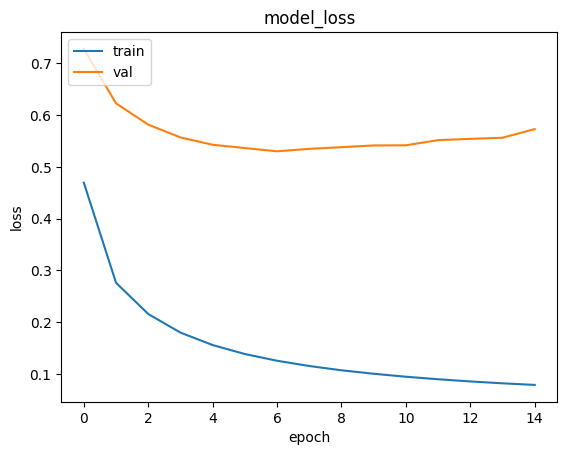

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluation

In [ ]:
seq2seq_gru.evaluate(val_dataset)

748/748 [==============================] - 90s 77ms/step - loss: 0.5730


0.5729756951332092

In [ ]:
# Instantiate the BLEU metric class
bleu = BLEU()
count = 0
# Loop over the validation dataset
for x, y in val_dataset:
  #
  if count==550:
    break
  # Get the input and shifted target from x
  input = x["input_1"]
  shifted_target = x["input_2"]

  # Predict the output using the model
  output = seq2seq_gru.predict([input, shifted_target])

  count+=1
  print(count)

  # Update the BLEU metric state with the true and predicted target
  bleu.update_state(y, output)



# Get the final BLEU score result
bleu_score = bleu.result()

# Print the BLEU score
print(f"BLEU score on validation dataset: {bleu_score:.4f}")


#Saving

In [ ]:
from tensorflow.keras.models import save_model



# Testing

In [ ]:
from tensorflow.keras.models import load_model
seq2seq_gru = load_model("/content/drive/MyDrive/NMT/seq2seq_gru.h5")


In [ ]:
index_to_word={x:y for x, y in zip(range(len(french_vectorize_layer.get_vocabulary())),
                                   french_vectorize_layer.get_vocabulary())}

In [ ]:
def translator(english_sentence):
  tokenized_english_sentence=english_vectorize_layer([english_sentence])
  shifted_target='starttoken'

  for i in range(FRENCH_SEQUENCE_LENGTH):
    tokenized_shifted_target=french_vectorize_layer([shifted_target])
    output=seq2seq_gru.predict([tokenized_english_sentence,tokenized_shifted_target])
    french_word_index=tf.argmax(output,axis=-1)[0][i].numpy()
    current_word=index_to_word[french_word_index]
    if current_word=='endtoken':
      break
    shifted_target+=' '+current_word
  return shifted_target[11:]

In [ ]:
translator('what is happening here?')

1/1 [==============================] - 0s 23ms/step


'que se passetil ici'

In [ ]:
word_to_index={y:x for x, y in zip(range(len(french_vectorize_layer.get_vocabulary())),
                                   french_vectorize_layer.get_vocabulary())}

In [ ]:
from tensorflow.keras.models import load_model
seq2seq_gru_test = load_model("/content/drive/MyDrive/NMT/seq2seq_gru.h5")


In [ ]:
import pickle
from tensorflow.keras.layers import TextVectorization
english_layer_data = pickle.load(open("/content/drive/MyDrive/NMT/english_vectorize_layer.pkl", "rb"))
french_layer_data = pickle.load(open("/content/drive/MyDrive/NMT/french_vectorize_layer.pkl", "rb"))
english_vectorize_layer_test = TextVectorization.from_config(english_layer_data['config'])
french_vectorize_layer_test = TextVectorization.from_config(french_layer_data['config'])
english_vectorize_layer_test.set_weights(english_layer_data['weights'])
french_vectorize_layer_test.set_weights(french_layer_data['weights'])


In [ ]:
def translator_test(english_sentence):
  tokenized_english_sentence=english_vectorize_layer_test([english_sentence])
  shifted_target='starttoken'

  for i in range(FRENCH_SEQUENCE_LENGTH):
    tokenized_shifted_target=french_vectorize_layer_test([shifted_target])
    output=seq2seq_gru.predict([tokenized_english_sentence,tokenized_shifted_target])
    french_word_index=tf.argmax(output,axis=-1)[0][i].numpy()
    current_word=index_to_word[french_word_index]
    if current_word=='endtoken':
      break
    shifted_target+=' '+current_word
  return shifted_target[11:]

In [ ]:
translator_test('what is happening here?')

1/1 [==============================] - 0s 105ms/step


'que se passetil ici'

In [ ]:
# Instantiate the BLEU metric class
bleu = BLEU()
count = 0
# Loop over the validation dataset
for x, y in val_dataset:
  #
  if count==550:
    break
  # Get the input and shifted target from x
  input = x["input_1"]
  shifted_target = x["input_2"]

  # Predict the output using the model
  output = seq2seq_gru_test.predict([input, shifted_target])

  count+=1
  print(count)

  # Update the BLEU metric state with the true and predicted target
  bleu.update_state(y, output)



# Get the final BLEU score result
bleu_score = bleu.result()

# Print the BLEU score
print(f"BLEU score on validation dataset: {bleu_score:.4f}")


2/2 [==============================] - 1s 11ms/step


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: not enough values to unpack (expected 2, got 0)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: not enough values to unpack (expected 2, got 0)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2/2 [==============================] - 0s 31ms/step
2
2/2 [==============================] - 0s 32ms/step
3
2/2 [==============================] - 0s 32ms/step
4
2/2 [==============================] - 0s 31ms/step
5
2/2 [==============================] - 0s 32ms/step
6
2/2 [==============================] - 0s 31ms/step
7
2/2 [==============================] - 0s 32ms/step
8
2/2 [==============================] - 0s 32ms/step
9
2/2 [==============================] - 0s 31ms/step
10
2/2 [==============================] - 0s 31ms/step
11
2/2 [==============================] - 0s 31ms/step
12
2/2 [==============================] - 0s 31ms/step
13
2/2 [==============================] 